In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import ggplot as gg
import pandas as pd
import numpy as np


%matplotlib inline
py.init_notebook_mode(connected=True)

C:\ProgramData\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning:

pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp

C:\ProgramData\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning:

The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
scores = pd.read_csv('scores_2.csv', index_col=0)
ratings = pd.read_csv("C:\\Users\\ll299\\Documents\\python_nctta_rating\\current_rating.csv", index_col=0)
ratings['current_rating'] = ratings['current_rating'].apply(lambda x: int(x.replace('[','').replace(']','')))
ratings['player_id'] = ratings['player_id'].apply(lambda x: int(x.replace('[','').replace(']','')))

In [3]:
#apply PauTu method to drop the outliers. 
import functools
def pautu(score,wlratio_mean, wlratio_std):
    mean = wlratio_mean[score['Ll']-1,score['Wl']-1]
    std = wlratio_std[score['Ll']-1, score['Wl']-1]
    return (mean-2.58*std<score['win_ratio']<mean+2.58*std)

In [4]:
# calculate the mean and std of w_L ratio of different levels. 
wlratio_mean = np.zeros((10,10))
wlratio_std = np.zeros((10,10))
def wlratio(scores_e, wlratio_mean, wlratio_std):
    for i in range(10):
        for j in range(10):
            wr = scores_e[(scores_e['Ll']==i+1) & (scores_e['Wl']==j+1)]['win_ratio']
            lr = 1-scores_e[(scores_e['Ll']==j+1) & (scores_e['Wl']==i+1)]['win_ratio']
            w_r_l=wr.append(lr)
            wlratio_mean[i,j]=np.mean(w_r_l)
            wlratio_std[i,j]=np.sqrt(np.var(w_r_l))
wlratio(scores, wlratio_mean, wlratio_std)    

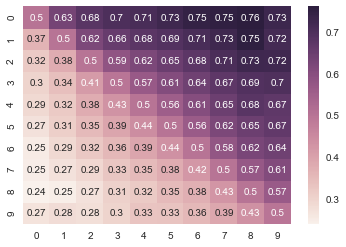

In [5]:
sns.heatmap(wlratio_mean, annot=True)

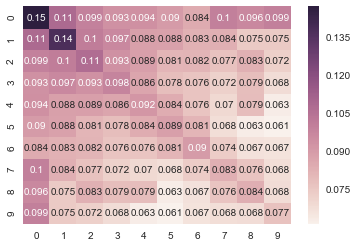

In [6]:
sns.heatmap(wlratio_std, annot=True)

In [7]:
scores_new = scores
for i in range(2):
    wlratio(scores_new, wlratio_mean, wlratio_std)  
    pautu_new = functools.partial(pautu, wlratio_mean = wlratio_mean, wlratio_std = wlratio_std)
    drop_list_temp = scores_new.apply(pautu_new, axis=1)
    scores_new = scores_new[drop_list_temp]

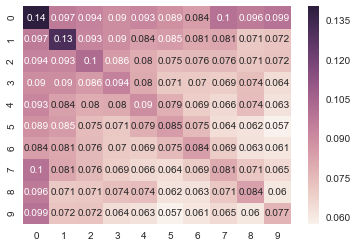

In [8]:
sns.heatmap(wlratio_std, annot=True)

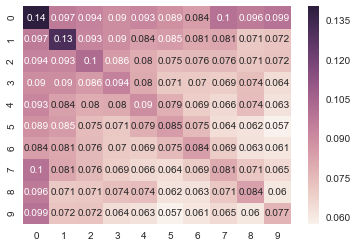

In [9]:
sns.heatmap(wlratio_std, annot=True)

In [26]:
def level(rating):
    level_range = [0,500,1000,1300,1600,1800,2000,2200,2400,2550,2800]
    for i in range(10):
        if level_range[i]<=rating<level_range[i+1]:
            return i+1

In [25]:
def get_info(w):
    dict_list = []
    for i in w.index.levels[0]:
        d = w.loc[i].to_dict()
        d['id'] = i
        dict_list.append(d)
    return pd.DataFrame.from_records(dict_list, index='id')

In [10]:
l=pd.Series(1-scores_new.groupby(['Loser_id','Wl']).mean().win_ratio)
lc = scores_new.groupby(['Loser_id','Wl']).count().win_ratio
w = pd.Series(scores_new.groupby(['Winner_id','Ll']).mean().win_ratio)
wc = scores_new.groupby(['Winner_id','Ll']).count().win_ratio
df_l = get_info(l*lc)
df_w = get_info(w*wc)
df_lc = get_info(lc)
df_wc = get_info(wc)

ratings.set_index('player_id', inplace=True)

dfm_l = ratings.merge(right = df_l, how='left', left_index=True, right_index=True, copy=True)
dfm_l.fillna(0, inplace = True)
dfm_lc = ratings.merge(right = df_lc, how='left', left_index=True, right_index=True, copy=True)
dfm_lc.fillna(0, inplace = True)
dfm_w = ratings.merge(right = df_w, how='left', left_index=True, right_index=True, copy=True)
dfm_w.fillna(0, inplace = True)
dfm_wc = ratings.merge(right = df_wc, how='left', left_index=True, right_index=True, copy=True)
dfm_wc.fillna(0, inplace = True)

In [17]:
players_history = (dfm_l+dfm_w)/(dfm_wc+dfm_lc)
players_history.fillna(0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4814: RuntimeWarning:

'<' not supported between instances of 'numpy.ndarray' and 'str', sort order is undefined for incomparable objects



In [18]:
players_history['current_rating']= ratings

In [19]:
players_history = players_history[[1,2,3,4,5,6,7,8,9,10,'current_rating']]

In [21]:
players_history['level']=players_history['current_rating'].apply(level)